In [ ]:
# Instant Insanity QUBO with Two-Axis Consideration (without fixed axis pre-definition)

from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# === Step 1. Define all face pairs from each die (3 face-pairs per die)
# No axis fixed; all face-pairs are candidates for selection

dice_faces = {
    1: [('R', 'R'), ('R', 'B'), ('W', 'G')],
    2: [('W', 'B'), ('R', 'B'), ('W', 'G')],
    3: [('W', 'G'), ('B', 'B'), ('R', 'G')],
    4: [('W', 'R'), ('W', 'B'), ('R', 'G')]
}


axes = ['z', 'x']  # 두 축

# 변수 매핑: (die, pair_idx, axis) -> variable index
variables = {}
reverse_variables = {}
idx = 0

for die in sorted(dice_faces.keys()):
    for pair_idx in range(len(dice_faces[die])):
        for axis in axes:
            variables[(die, pair_idx, axis)] = idx
            reverse_variables[idx] = (die, pair_idx, axis)
            idx += 1

num_variables = idx
Q = np.zeros((num_variables, num_variables))

# 제약 계수
A = 1.0    # 축 선택
B = 1.0    # 색상 중복 방지
C = 1.0    # 축 중복 억제
D = 1.0    # 색상 최소 1회 등장

# (C1) 각 주사위에 대해 축당 하나만 선택
#for die in sorted(dice_faces.keys()):
#    for axis in axes:
#        var_list = [variables[(die, pair_idx, axis)] for pair_idx in range(len(dice_faces[die]))]
#        for i in var_list:
#            Q[i, i] += A
#        for i, j in combinations(var_list, 2):
#            Q[i, j] += 2 * A
#        for i in var_list:
#            Q[i, i] += -2 * A
            

# (C2) 같은 면쌍의 두 축 사용 억제
for die in sorted(dice_faces.keys()):
    for pair_idx in range(len(dice_faces[die])):
        i = variables[(die, pair_idx, 'z')]
        j = variables[(die, pair_idx, 'x')]

        Q[i, i] += C        # x_z^2
        Q[j, j] += C        # x_x^2
        Q[i, j] += 2 * C    # 2 x_z x_x
        Q[i, i] += -2 * C   # -2 x_z
        Q[j, j] += -2 * C   # -2 x_x


# (C3) 색상 중복 방지 (축별로 앞면/뒷면 분리)
for axis in axes:
    front_colors = defaultdict(list)
    back_colors = defaultdict(list)
    
    for (die, pair_idx, ax), var_idx in variables.items():
        if ax != axis:
            continue
        front, back = dice_faces[die][pair_idx]
        front_colors[front].append(var_idx)
        back_colors[back].append(var_idx)
    
    for color_vars in [front_colors, back_colors]:
        for color, var_list in color_vars.items():
            for i, j in combinations(var_list, 2):
                Q[i, j] += B

# (C4) 모든 색상 사용 강제: 각 색상은 적어도 한 번은 앞/뒤에 나와야 함
color_set = {'R', 'G', 'B', 'W'}
for axis in axes:
    for color in color_set:
        # 해당 색상을 갖는 변수들 (앞면과 뒷면 포함)
        color_vars = []
        for (die, idx, ax), v in variables.items():
            if ax != axis:
                continue
            front, back = dice_faces[die][idx]
            if front == color or back == color:
                color_vars.append(v)
        
        # 제약식: (1 - x1 - x2 - ... - xn)^2
        for i in color_vars:
            Q[i, i] += D  # xi^2
        for i, j in combinations(color_vars, 2):
            Q[i, j] += 2 * D  # 2 xi xj
        for i in color_vars:
            Q[i, i] += -2 * D  # -2 xi
        # 상수항 1은 해밀토니안에서 생략 가능하므로 포함 안 함



# === Step 4. Convert QUBO to SparsePauliOp Hamiltonian ===
from qiskit.quantum_info import SparsePauliOp

def qubo_to_cost_hamiltonian(Q):
    n = Q.shape[0]
    pauli_terms = {}
    for i in range(n):
        if abs(Q[i, i]) > 1e-8:
            coeff = Q[i, i] / 2
            key = ['I'] * n
            key[i] = 'Z'
            key_str = ''.join(key[::-1])
            pauli_terms[key_str] = pauli_terms.get(key_str, 0) - coeff
            pauli_terms['I'*n] = pauli_terms.get('I'*n, 0) + coeff
        for j in range(i + 1, n):
            if abs(Q[i, j]) > 1e-8:
                coeff = Q[i, j] / 4
                zi = ['I'] * n
                zi[i] = 'Z'
                pauli_terms[''.join(zi[::-1])] = pauli_terms.get(''.join(zi[::-1]), 0) - coeff
                zj = ['I'] * n
                zj[j] = 'Z'
                pauli_terms[''.join(zj[::-1])] = pauli_terms.get(''.join(zj[::-1]), 0) - coeff
                zij = ['I'] * n
                zij[i] = 'Z'
                zij[j] = 'Z'
                pauli_terms[''.join(zij[::-1])] = pauli_terms.get(''.join(zij[::-1]), 0) + coeff
                pauli_terms['I'*n] = pauli_terms.get('I'*n, 0) + coeff
    return SparsePauliOp.from_list([(p, c) for p, c in pauli_terms.items()])

cost_hamiltonian = qubo_to_cost_hamiltonian(Q)


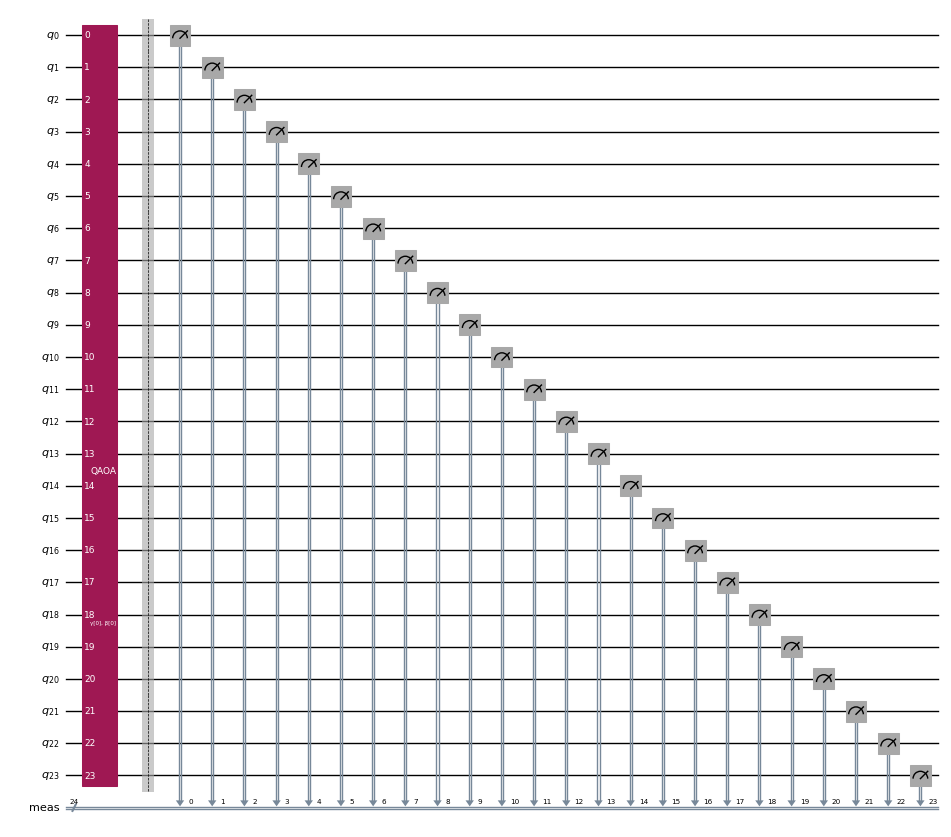

In [142]:
from qiskit.circuit.library import QAOAAnsatz

qaoa_ansatz = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
qaoa_ansatz.measure_all()

# 회로 시각화
qaoa_ansatz.draw("mpl", fold=-1, scale=0.5, idle_wires=False)


In [143]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit import ParameterVector
import numpy as np
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator


backend = AerSimulator()

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
candidate_circuit = pm.run(qaoa_ansatz)

print(qaoa_ansatz.parameters)

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])


In [144]:
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = [initial_gamma, initial_beta]
objective_func_vals = [] # Global variable

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [145]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-8,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 45.14359999999999
       x: [ 4.269e+00  1.502e+00]
    nfev: 48
   maxcv: 0.0


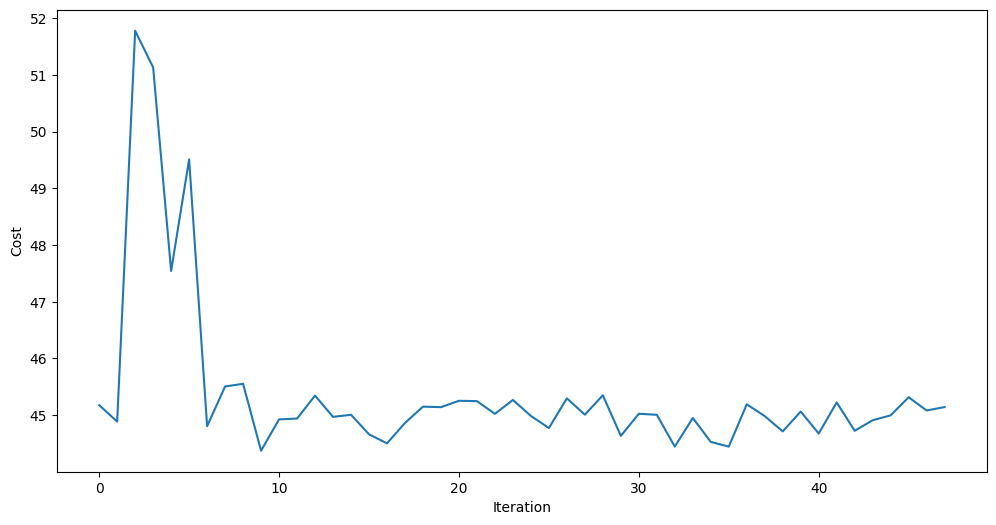

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [127]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
bound_circuit = qaoa_ansatz.assign_parameters(result.x)
isa_bound_circuit = pm.run(bound_circuit)
job = sampler.run([isa_bound_circuit])
samples = job.result()[0].data.meas.get_counts()
print(samples)


{'110110100000001100111010': 1, '000110011011001100111000': 1, '101011100000010100000111': 1, '101010111111000000010010': 1, '100101100111000101000011': 1, '101001111010110011100111': 1, '111110110001101100001001': 1, '110011111110001100010010': 1, '110001010111010000100110': 1, '110001110100100110011011': 1, '000000100010001000010100': 1, '011000101101000001001100': 1, '000000011101000110001000': 1, '100010110110000110000011': 1, '011110111110100100011010': 1, '110000000100100010000110': 1, '010000000110101100001100': 1, '010000110100011100011110': 1, '010111110011001001110011': 1, '110000011010011110100001': 1, '010011001101010001110000': 1, '010110110111101111000101': 1, '101010001110001010111000': 1, '010101011011110011111110': 1, '101010001110110101010010': 1, '010001000110000100000011': 1, '111110001101000110110111': 1, '010111001010011000011001': 1, '010111010100010000010000': 1, '001100010111110000011000': 1, '000111001001001100000011': 1, '000101101110011011001010': 1, '011000

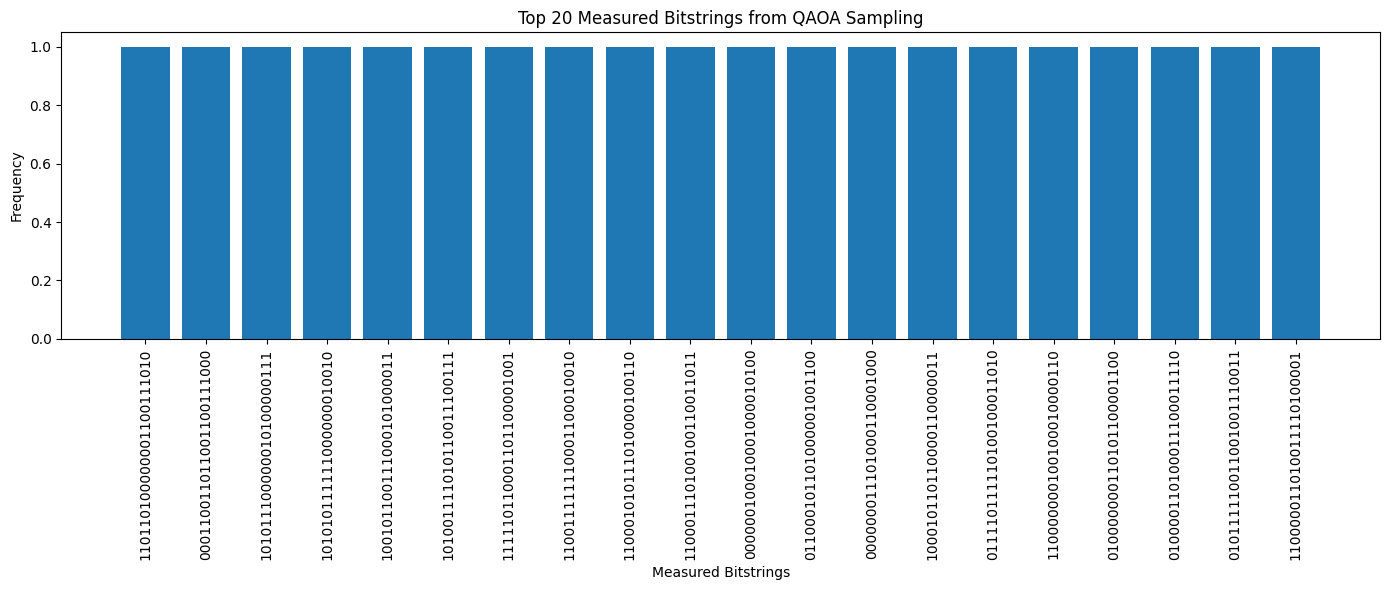

In [129]:
import matplotlib.pyplot as plt
from collections import Counter

# 예시: QAOA 측정 결과를 딕셔너리 형태로 저장


# 시각화에 사용할 최상위 k개만 추출
top_k = 20
most_common = Counter(samples).most_common(top_k)

bitstrings = [x[0] for x in most_common]
frequencies = [x[1] for x in most_common]

# 시각화
plt.figure(figsize=(14, 6))
plt.bar(range(len(bitstrings)), frequencies, tick_label=bitstrings)
plt.xticks(rotation=90)
plt.xlabel("Measured Bitstrings")
plt.ylabel("Frequency")
plt.title(f"Top {top_k} Measured Bitstrings from QAOA Sampling")
plt.tight_layout()
plt.show()


In [130]:
from collections import Counter


# 최빈값 상위 2개 추출
top_2 = Counter(samples).most_common(2)

for idx_rank, (bitstring, count) in enumerate(top_2, 1):
    print(f"\n[Top {idx_rank}] Bitstring: {bitstring}  (Count: {count})")
    
    # Qiskit은 오른쪽이 qubit 0 → 역순
    selected_indices = [i for i, bit in enumerate(bitstring[::-1]) if bit == '1']
    
    used_dice = set()
    front_colors = []
    back_colors = []
    
    for var_idx in selected_indices:
        die, pair_idx, axis = reverse_variables[var_idx]
        front, back = dice_faces[die][pair_idx]
        used_dice.add(die)
        front_colors.append(front)
        back_colors.append(back)
        print(f" - 주사위 {die} / 축 {axis}: = {front},  = {back}")
    
    print(f"사용된 주사위 수: {len(used_dice)} / 색상 (앞면): {set(front_colors)} / 색상 (뒷면): {set(back_colors)}")



[Top 1] Bitstring: 110110100000001100111010  (Count: 1)
 - 주사위 1 / 축 x: = R,  = R
 - 주사위 1 / 축 x: = R,  = B
 - 주사위 1 / 축 z: = W,  = G
 - 주사위 1 / 축 x: = W,  = G
 - 주사위 2 / 축 z: = R,  = B
 - 주사위 2 / 축 x: = R,  = B
 - 주사위 3 / 축 x: = R,  = G
 - 주사위 4 / 축 x: = W,  = R
 - 주사위 4 / 축 z: = W,  = B
 - 주사위 4 / 축 z: = R,  = G
 - 주사위 4 / 축 x: = R,  = G
사용된 주사위 수: 4 / 색상 (앞면): {'R', 'W'} / 색상 (뒷면): {'G', 'B', 'R'}

[Top 2] Bitstring: 000110011011001100111000  (Count: 1)
 - 주사위 1 / 축 x: = R,  = B
 - 주사위 1 / 축 z: = W,  = G
 - 주사위 1 / 축 x: = W,  = G
 - 주사위 2 / 축 z: = R,  = B
 - 주사위 2 / 축 x: = R,  = B
 - 주사위 3 / 축 z: = W,  = G
 - 주사위 3 / 축 x: = W,  = G
 - 주사위 3 / 축 x: = B,  = B
 - 주사위 3 / 축 z: = R,  = G
 - 주사위 4 / 축 x: = W,  = R
 - 주사위 4 / 축 z: = W,  = B
사용된 주사위 수: 4 / 색상 (앞면): {'B', 'R', 'W'} / 색상 (뒷면): {'G', 'B', 'R'}
